In [1]:
import numpy as np
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import string
import tensorflow
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
import os
import pickle

In [2]:
import nltk
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 # PEGASUS

## SMS Spam Data

In [6]:
df = pd.read_csv("/content/drive/MyDrive/sms_v2.csv")

In [4]:
augmented_dataset = pd.read_csv("/content/drive/MyDrive/EnsembleLearningProject/pegasus/sms_aug_pegasus.csv")

In [9]:
augmented_dataset.columns

Index(['true name is rofl', 'Non-Spam'], dtype='object')

In [8]:
df.rename(columns={'Rofl. Its true to its name': 'Message', 'Non-Spam': 'Category'}, inplace=True)

In [10]:
augmented_dataset.columns
augmented_dataset.rename(columns={'true name is rofl': 'Message', 'Non-Spam': 'Category'}, inplace=True)

In [11]:
#BAŞTA
df_top=pd.concat([augmented_dataset,df],ignore_index=True)
df_top.count()

#ORTADA
df_mid = pd.concat([df.iloc[:250], augmented_dataset, df.iloc[250:]]).reset_index(drop=True)

#SONDA
df_tail =pd.concat([df,augmented_dataset],ignore_index=True)
df_tail.count()


Message     986
Category    986
dtype: int64

In [12]:
df_top.drop_duplicates(inplace = True)
df_mid.drop_duplicates(inplace = True)
df_tail.drop_duplicates(inplace = True)

In [13]:
df_top.rename(columns={'Text': 'Message', 'Non-Spam': 'Category'}, inplace=True)
df_mid.rename(columns={'Text': 'Message', 'Non-Spam': 'Category'}, inplace=True)
df_tail.rename(columns={'Text': 'Message', 'Non-Spam': 'Category'}, inplace=True)

In [14]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]+', ' ', text)
    text = re.sub(r'[0-9]', '', text)
    translator = str.maketrans("", "", string.punctuation)
    text = text.translate(translator)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words("english")]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = " ".join(words)
    return text

### BAŞTA

In [15]:
df_top["Message"] = df_top.Message.map(preprocess) 

In [16]:
maxSeq = len(df_top["Message"][0])
for i in range (0,len(df_top["Message"])):
  try:
      cur = len(df_top["Message"][i])
      if (cur > maxSeq):
          maxSeq = cur
  except:
      pass

In [17]:
from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df_top.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

In [18]:
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_top['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [19]:
X = tokenizer.texts_to_sequences(df_top['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (976, 327)


In [20]:
from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df_top['Category'] = labelencoder.fit_transform(df_top['Category'])
Y = df_top['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (976,)


In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(732, 327) (732,)
(244, 327) (244,)


In [22]:
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [23]:
model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(16))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

print(history.model.summary())

Epoch 1/10
5/5 [==============================] - 7s 140ms/step - loss: 0.6877 - accuracy: 0.6291 - val_loss: 0.6673 - val_accuracy: 0.8844
Epoch 2/10
5/5 [==============================] - 0s 29ms/step - loss: 0.6496 - accuracy: 0.9248 - val_loss: 0.6333 - val_accuracy: 0.8844
Epoch 3/10
5/5 [==============================] - 0s 29ms/step - loss: 0.6081 - accuracy: 0.9282 - val_loss: 0.5925 - val_accuracy: 0.8776
Epoch 4/10
5/5 [==============================] - 0s 25ms/step - loss: 0.5566 - accuracy: 0.9299 - val_loss: 0.5394 - val_accuracy: 0.8776
Epoch 5/10
5/5 [==============================] - 0s 24ms/step - loss: 0.4892 - accuracy: 0.9282 - val_loss: 0.4689 - val_accuracy: 0.8776
Epoch 6/10
5/5 [==============================] - 0s 20ms/step - loss: 0.4029 - accuracy: 0.9265 - val_loss: 0.3848 - val_accuracy: 0.8707
Epoch 7/10
5/5 [==============================] - 0s 21ms/step - loss: 0.3090 - accuracy: 0.9231 - val_loss: 0.3151 - val_accuracy: 0.8707
Epoch 8/10
5/5 [==========

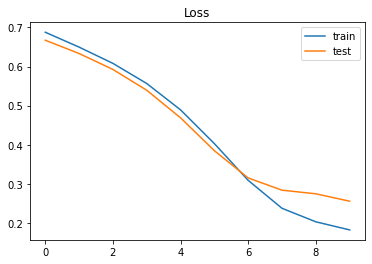

In [24]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


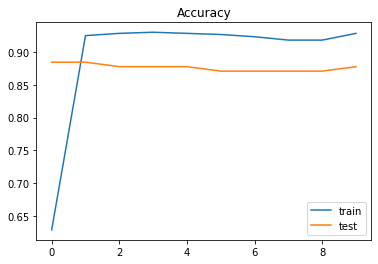

In [25]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()


In [26]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)


8/8 - 0s - 412ms/epoch - 52ms/step


In [27]:
from sklearn.metrics import classification_report
target_names = ['not spam','spam']
print(classification_report(Y_test, result, target_names=target_names))

              precision    recall  f1-score   support

    not spam       0.88      1.00      0.94       211
        spam       1.00      0.12      0.22        33

    accuracy                           0.88       244
   macro avg       0.94      0.56      0.58       244
weighted avg       0.90      0.88      0.84       244



In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df

,not spam,spam
not spam,211,0
spam,29,4


### ORTADA

In [29]:
df_mid["Message"] = df_mid.Message.map(preprocess) 
maxSeq = len(df_mid["Message"][0])
for i in range (0,len(df_mid["Message"])):
  try:
      cur = len(df_mid["Message"][i])
      if (cur > maxSeq):
          maxSeq = cur
  except:
      pass

In [30]:
from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df_mid.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_mid['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

X = tokenizer.texts_to_sequences(df_mid['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (976, 327)


In [31]:
from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df_mid['Category'] = labelencoder.fit_transform(df_mid['Category'])
Y = df_mid['Category'].values
print('Shape of label tensor:', Y.shape)


Shape of label tensor: (976,)


In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(732, 327) (732,)
(244, 327) (244,)


In [33]:
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping


model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

print(history.model.summary())


Epoch 1/10
5/5 [==============================] - 2s 133ms/step - loss: 0.6767 - accuracy: 0.7624 - val_loss: 0.6376 - val_accuracy: 0.8980
Epoch 2/10
5/5 [==============================] - 0s 29ms/step - loss: 0.6133 - accuracy: 0.8803 - val_loss: 0.5598 - val_accuracy: 0.8980
Epoch 3/10
5/5 [==============================] - 0s 25ms/step - loss: 0.5244 - accuracy: 0.8786 - val_loss: 0.4386 - val_accuracy: 0.8980
Epoch 4/10
5/5 [==============================] - 0s 23ms/step - loss: 0.3948 - accuracy: 0.8786 - val_loss: 0.3089 - val_accuracy: 0.8980
Epoch 5/10
5/5 [==============================] - 0s 22ms/step - loss: 0.3139 - accuracy: 0.8786 - val_loss: 0.2835 - val_accuracy: 0.8980
Epoch 6/10
5/5 [==============================] - 0s 23ms/step - loss: 0.3027 - accuracy: 0.8786 - val_loss: 0.2672 - val_accuracy: 0.8980
Epoch 7/10
5/5 [==============================] - 0s 23ms/step - loss: 0.2678 - accuracy: 0.8821 - val_loss: 0.2387 - val_accuracy: 0.8980
Epoch 8/10
5/5 [==========

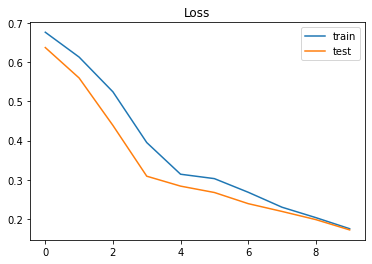

In [34]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

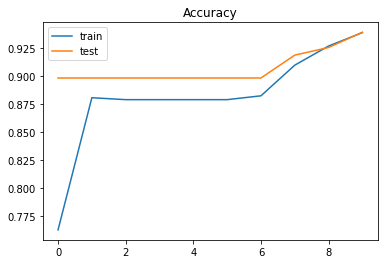

In [35]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [36]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)

8/8 - 0s - 411ms/epoch - 51ms/step


In [37]:
from sklearn.metrics import classification_report
target_names = ['not spam','spam']
print(classification_report(Y_test, result, target_names=target_names))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df


              precision    recall  f1-score   support

    not spam       0.93      1.00      0.96       215
        spam       1.00      0.41      0.59        29

    accuracy                           0.93       244
   macro avg       0.96      0.71      0.77       244
weighted avg       0.94      0.93      0.92       244



,not spam,spam
not spam,215,0
spam,17,12


### SONDA

In [38]:
df_tail["Message"] = df_tail.Message.map(preprocess) 

maxSeq = len(df_tail["Message"][0])
for i in range (0,len(df_tail["Message"])):
    try:
        cur = len(df_tail["Message"][i])
        if (cur > maxSeq):
            maxSeq = cur
    except:
        pass
      
from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df_tail.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

#ÖN İŞLEME-5
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_tail['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
#ÖN İŞLEME-6    
X = tokenizer.texts_to_sequences(df_tail['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

#ÖN İŞLEME-7
from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df_tail['Category'] = labelencoder.fit_transform(df_tail['Category'])
Y = df_tail['Category'].values
print('Shape of label tensor:', Y.shape)


Shape of data tensor: (976, 327)
Shape of label tensor: (976,)


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(732, 327) (732,)
(244, 327) (244,)


In [40]:
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping


In [41]:
model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

print(history.model.summary())

Epoch 1/10
5/5 [==============================] - 2s 134ms/step - loss: 0.6817 - accuracy: 0.6923 - val_loss: 0.6469 - val_accuracy: 0.8844
Epoch 2/10
5/5 [==============================] - 0s 29ms/step - loss: 0.6211 - accuracy: 0.8889 - val_loss: 0.5775 - val_accuracy: 0.8844
Epoch 3/10
5/5 [==============================] - 0s 24ms/step - loss: 0.5374 - accuracy: 0.8872 - val_loss: 0.4679 - val_accuracy: 0.8844
Epoch 4/10
5/5 [==============================] - 0s 23ms/step - loss: 0.4119 - accuracy: 0.8872 - val_loss: 0.3457 - val_accuracy: 0.8844
Epoch 5/10
5/5 [==============================] - 0s 22ms/step - loss: 0.3160 - accuracy: 0.8872 - val_loss: 0.3094 - val_accuracy: 0.8844
Epoch 6/10
5/5 [==============================] - 0s 23ms/step - loss: 0.3016 - accuracy: 0.8872 - val_loss: 0.3066 - val_accuracy: 0.8844
Epoch 7/10
5/5 [==============================] - 0s 22ms/step - loss: 0.2798 - accuracy: 0.8872 - val_loss: 0.2718 - val_accuracy: 0.8844
Epoch 8/10
5/5 [==========

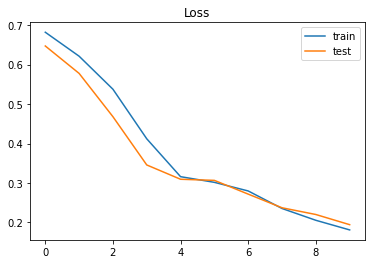

In [42]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

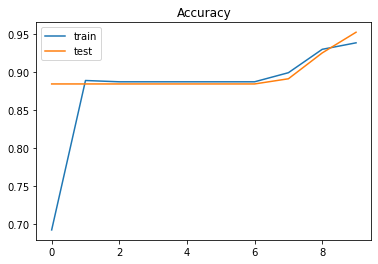

In [43]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()


In [44]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)


8/8 - 0s - 398ms/epoch - 50ms/step


In [45]:
from sklearn.metrics import classification_report
target_names = ['not spam','spam']
print(classification_report(Y_test, result, target_names=target_names))

   
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df


              precision    recall  f1-score   support

    not spam       0.89      1.00      0.94       212
        spam       1.00      0.22      0.36        32

    accuracy                           0.90       244
   macro avg       0.95      0.61      0.65       244
weighted avg       0.91      0.90      0.87       244



,not spam,spam
not spam,212,0
spam,25,7


## Twitter Sentiment Analysis

In [46]:
df = pd.read_csv("/content/drive/MyDrive/sentiment_v2.csv")
augmented_dataset = pd.read_csv("/content/drive/MyDrive/EnsembleLearningProject/pegasus/sentiment_aug_pegasus.csv")

In [47]:
augmented_dataset.columns

Index(['Everyone felt the climate change question last night.', 'Neutral'], dtype='object')

In [48]:
df.rename(columns={'RT  NancyLeeGrahn  How did everyone feel about the Climate Change question last night  Exactly.  GOPDebate': 'Message', 'Neutral': 'Category'}, inplace=True)
augmented_dataset.rename(columns={'Everyone felt the climate change question last night.': 'Message', 'Neutral': 'Category'}, inplace=True)

In [49]:
#BAŞTA
df_top=pd.concat([augmented_dataset,df],ignore_index=True)

#ORTADA
df_mid = pd.concat([df.iloc[:250], augmented_dataset, df.iloc[250:]]).reset_index(drop=True)

#SONDA
df_tail =pd.concat([df,augmented_dataset],ignore_index=True)

In [50]:
df_top.drop_duplicates(inplace = True)
df_mid.drop_duplicates(inplace = True)
df_tail.drop_duplicates(inplace = True)

In [ ]:
"""df_top.rename(columns={'Text': 'Message', 'Non-Spam': 'Category'}, inplace=True)
df_mid.rename(columns={'Text': 'Message', 'Non-Spam': 'Category'}, inplace=True)
df_tail.rename(columns={'Text': 'Message', 'Non-Spam': 'Category'}, inplace=True)"""

"df_top.rename(columns={'Text': 'Message', 'Non-Spam': 'Category'}, inplace=True)\ndf_mid.rename(columns={'Text': 'Message', 'Non-Spam': 'Category'}, inplace=True)\ndf_tail.rename(columns={'Text': 'Message', 'Non-Spam': 'Category'}, inplace=True)"

In [51]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]+', ' ', text)
    text = re.sub(r'[0-9]', '', text)
    translator = str.maketrans("", "", string.punctuation)
    text = text.translate(translator)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words("english")]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = " ".join(words)
    return text

###BAŞTA

In [52]:
df_top["Message"] = df_top.Message.map(preprocess) 

maxSeq = len(df_top["Message"][0])
for i in range (0,len(df_top["Message"])):
    try:
        cur = len(df_top["Message"][i])
        if (cur > maxSeq):
            maxSeq = cur
    except:
        pass

from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df_top.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_top['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

X = tokenizer.texts_to_sequences(df_top['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df_top['Category'] = labelencoder.fit_transform(df_top['Category'])
Y = df_top['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (983, 185)
Shape of label tensor: (983,)


In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

#MODEL KURULMASI
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping


model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

print(history.model.summary())

(737, 185) (737,)
(246, 185) (246,)
Epoch 1/10
5/5 [==============================] - 2s 128ms/step - loss: 0.6895 - accuracy: 0.2971 - val_loss: 0.6821 - val_accuracy: 0.2297
Epoch 2/10
5/5 [==============================] - 0s 22ms/step - loss: 0.6727 - accuracy: 0.2139 - val_loss: 0.6690 - val_accuracy: 0.2297
Epoch 3/10
5/5 [==============================] - 0s 23ms/step - loss: 0.6484 - accuracy: 0.2139 - val_loss: 0.6556 - val_accuracy: 0.2297
Epoch 4/10
5/5 [==============================] - 0s 20ms/step - loss: 0.6194 - accuracy: 0.2139 - val_loss: 0.6440 - val_accuracy: 0.2297
Epoch 5/10
5/5 [==============================] - 0s 18ms/step - loss: 0.5742 - accuracy: 0.2173 - val_loss: 0.6223 - val_accuracy: 0.2365
Epoch 6/10
5/5 [==============================] - 0s 17ms/step - loss: 0.5085 - accuracy: 0.2903 - val_loss: 0.5921 - val_accuracy: 0.2635
Epoch 7/10
5/5 [==============================] - 0s 17ms/step - loss: 0.4031 - accuracy: 0.3328 - val_loss: 0.5712 - val_accurac

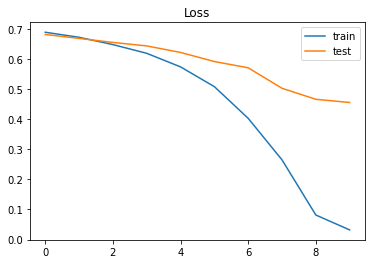

In [54]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

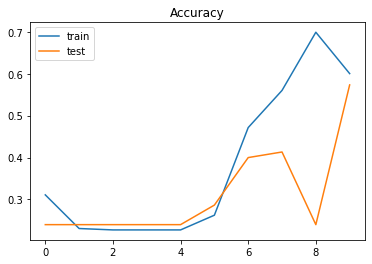

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [55]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)

from sklearn.metrics import classification_report
target_names = ['positive','negative','neutral']
print(classification_report(Y_test, result, target_names=target_names))

   
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df

8/8 - 0s - 372ms/epoch - 46ms/step
              precision    recall  f1-score   support

    positive       0.85      0.70      0.77       126
    negative       0.40      0.86      0.55        66
     neutral       0.00      0.00      0.00        54

    accuracy                           0.59       246
   macro avg       0.42      0.52      0.44       246
weighted avg       0.54      0.59      0.54       246



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,positive,negative,neutral
positive,88,38,0
negative,9,57,0
neutral,7,47,0


### ORTADA

In [56]:
df_mid["Message"] = df_mid.Message.map(preprocess) 

maxSeq = len(df_mid["Message"][0])
for i in range (0,len(df_mid["Message"])):
    try:
        cur = len(df_mid["Message"][i])
        if (cur > maxSeq):
            maxSeq = cur
    except:
        pass

from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df_mid.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_mid['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

X = tokenizer.texts_to_sequences(df_mid['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df_mid['Category'] = labelencoder.fit_transform(df_mid['Category'])
Y = df_mid['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (983, 185)
Shape of label tensor: (983,)


In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

#MODEL KURULMASI
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping


model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

print(history.model.summary())

(737, 185) (737,)
(246, 185) (246,)
Epoch 1/10
5/5 [==============================] - 3s 171ms/step - loss: 0.6903 - accuracy: 0.3820 - val_loss: 0.6866 - val_accuracy: 0.2432
Epoch 2/10
5/5 [==============================] - 0s 22ms/step - loss: 0.6682 - accuracy: 0.2326 - val_loss: 0.6782 - val_accuracy: 0.2432
Epoch 3/10
5/5 [==============================] - 0s 21ms/step - loss: 0.6411 - accuracy: 0.2326 - val_loss: 0.6701 - val_accuracy: 0.2432
Epoch 4/10
5/5 [==============================] - 0s 20ms/step - loss: 0.6059 - accuracy: 0.2326 - val_loss: 0.6710 - val_accuracy: 0.2432
Epoch 5/10
5/5 [==============================] - 0s 19ms/step - loss: 0.5552 - accuracy: 0.2326 - val_loss: 0.6625 - val_accuracy: 0.2432
Epoch 6/10
5/5 [==============================] - 0s 19ms/step - loss: 0.4807 - accuracy: 0.2632 - val_loss: 0.6227 - val_accuracy: 0.2635
Epoch 7/10
5/5 [==============================] - 0s 19ms/step - loss: 0.3684 - accuracy: 0.3514 - val_loss: 0.5892 - val_accurac

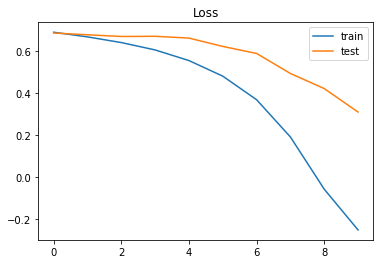

In [58]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

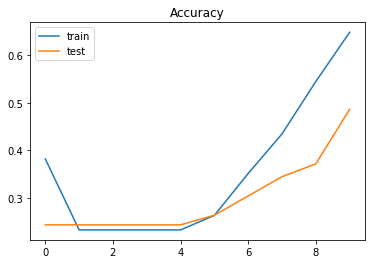

In [59]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [60]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)

from sklearn.metrics import classification_report
target_names = ['positive','negative','neutral']
print(classification_report(Y_test, result, target_names=target_names))

   
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df

8/8 - 0s - 386ms/epoch - 48ms/step
              precision    recall  f1-score   support

    positive       0.89      0.59      0.71       142
    negative       0.29      0.83      0.43        53
     neutral       0.00      0.00      0.00        51

    accuracy                           0.52       246
   macro avg       0.39      0.47      0.38       246
weighted avg       0.58      0.52      0.50       246



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,positive,negative,neutral
positive,84,58,0
negative,9,44,0
neutral,1,50,0


###SONDA

In [61]:
df_tail["Message"] = df_tail.Message.map(preprocess) 

maxSeq = len(df_tail["Message"][0])
for i in range (0,len(df_tail["Message"])):
    try:
        cur = len(df_tail["Message"][i])
        if (cur > maxSeq):
            maxSeq = cur
    except:
        pass

from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df_tail.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_tail['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

X = tokenizer.texts_to_sequences(df_tail['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df_tail['Category'] = labelencoder.fit_transform(df_tail['Category'])
Y = df_tail['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (983, 185)
Shape of label tensor: (983,)


In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping


model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

print(history.model.summary())

(737, 185) (737,)
(246, 185) (246,)
Epoch 1/10
5/5 [==============================] - 2s 125ms/step - loss: 0.6890 - accuracy: 0.3277 - val_loss: 0.6841 - val_accuracy: 0.2500
Epoch 2/10
5/5 [==============================] - 0s 22ms/step - loss: 0.6635 - accuracy: 0.2360 - val_loss: 0.6735 - val_accuracy: 0.2500
Epoch 3/10
5/5 [==============================] - 0s 22ms/step - loss: 0.6336 - accuracy: 0.2343 - val_loss: 0.6589 - val_accuracy: 0.2500
Epoch 4/10
5/5 [==============================] - 0s 20ms/step - loss: 0.5889 - accuracy: 0.2343 - val_loss: 0.6470 - val_accuracy: 0.2500
Epoch 5/10
5/5 [==============================] - 0s 18ms/step - loss: 0.5329 - accuracy: 0.2343 - val_loss: 0.6406 - val_accuracy: 0.2500
Epoch 6/10
5/5 [==============================] - 0s 18ms/step - loss: 0.4543 - accuracy: 0.2513 - val_loss: 0.5957 - val_accuracy: 0.2568
Epoch 7/10
5/5 [==============================] - 0s 18ms/step - loss: 0.3363 - accuracy: 0.3396 - val_loss: 0.5396 - val_accurac

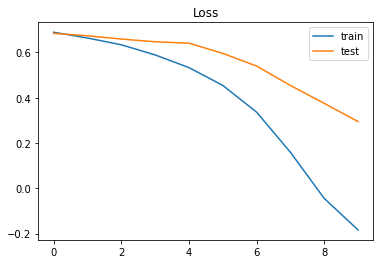

In [63]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

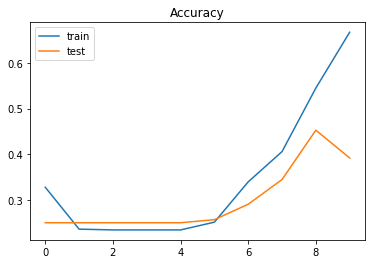

In [64]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [65]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)

from sklearn.metrics import classification_report
target_names = ['positive','negative','neutral']
print(classification_report(Y_test, result, target_names=target_names))

   
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df

8/8 - 0s - 380ms/epoch - 48ms/step
              precision    recall  f1-score   support

    positive       0.98      0.35      0.52       147
    negative       0.26      1.00      0.42        51
     neutral       0.00      0.00      0.00        48

    accuracy                           0.42       246
   macro avg       0.42      0.45      0.31       246
weighted avg       0.64      0.42      0.40       246



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,positive,negative,neutral
positive,52,95,0
negative,0,51,0
neutral,1,47,0


## Fake News Data

In [69]:
df = pd.read_csv("/content/drive/MyDrive/news_v2.csv")
augmented_dataset = pd.read_csv("/content/drive/MyDrive/EnsembleLearningProject/pegasus/news_aug_pegasus.csv")

In [71]:
augmented_dataset.columns

Index(['We have reported many cases of muslim refugees committing fraud and other groups stealing government funds.', 'Real'], dtype='object')

In [72]:
df.rename(columns={'print they should pay all the back all the money plus interest the entire family and everyone who came in with them need to be deported asap why did it take two years to bust them  here we go again another group stealing from the government and taxpayers a group of somalis stole over four million in government benefits over just  months  weve reported on numerous cases like this one where the muslim refugeesimmigrants commit fraud by scamming our systemits way out of control more related': 'Message', 'Real': 'Category'}, inplace=True)
augmented_dataset.rename(columns={'We have reported many cases of muslim refugees committing fraud and other groups stealing government funds.': 'Message', 'Real': 'Category'}, inplace=True)

In [73]:
#BAŞTA
df_top=pd.concat([augmented_dataset,df],ignore_index=True)

#ORTADA
df_mid = pd.concat([df.iloc[:250], augmented_dataset, df.iloc[250:]]).reset_index(drop=True)

#SONDA
df_tail =pd.concat([df,augmented_dataset],ignore_index=True)

In [74]:
df_top.drop_duplicates(inplace = True)
df_mid.drop_duplicates(inplace = True)
df_tail.drop_duplicates(inplace = True)

### BAŞTA

In [75]:
df_top["Message"] = df_top["Message"].str.lower()

In [76]:
df_top['Message']= df_top['Message'].str.replace(r'[^A-Za-z0-9 .]+', ' ') 

maxSeq = len(df_top["Message"][0])
for i in range (0,len(df_top["Message"])):
    try:
        cur = len(df_top["Message"][i])
        if (cur > maxSeq):
            maxSeq = cur
    except:
        pass

<ipython-input-76-7ca10b9392c7>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_top['Message']= df_top['Message'].str.replace(r'[^A-Za-z0-9 .]+', ' ')


In [77]:
df_top.dropna(inplace=True)

In [78]:
from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df_top.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_top['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
X = tokenizer.texts_to_sequences(df_top['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df_top['Category'] = labelencoder.fit_transform(df_top['Category'])
Y = df_top['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (926, 29508)
Shape of label tensor: (926,)


In [79]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(694, 29508) (694,)
(232, 29508) (232,)


In [80]:
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


print(history.model.summary())

Epoch 1/10
5/5 [==============================] - 8s 1s/step - loss: 0.6840 - accuracy: 0.7477 - val_loss: 0.6671 - val_accuracy: 0.8417
Epoch 2/10
5/5 [==============================] - 6s 1s/step - loss: 0.6449 - accuracy: 0.8973 - val_loss: 0.6322 - val_accuracy: 0.8417
Epoch 3/10
5/5 [==============================] - 6s 1s/step - loss: 0.5867 - accuracy: 0.8955 - val_loss: 0.5741 - val_accuracy: 0.8417
Epoch 4/10
5/5 [==============================] - 6s 1s/step - loss: 0.4862 - accuracy: 0.8955 - val_loss: 0.4731 - val_accuracy: 0.8417
Epoch 5/10
5/5 [==============================] - 6s 1s/step - loss: 0.3293 - accuracy: 0.8955 - val_loss: 0.4417 - val_accuracy: 0.8417
Epoch 6/10
5/5 [==============================] - 6s 1s/step - loss: 0.2874 - accuracy: 0.8955 - val_loss: 0.4978 - val_accuracy: 0.8417
Epoch 7/10
5/5 [==============================] - 6s 1s/step - loss: 0.2788 - accuracy: 0.8955 - val_loss: 0.4598 - val_accuracy: 0.8417
Epoch 8/10
5/5 [=========================

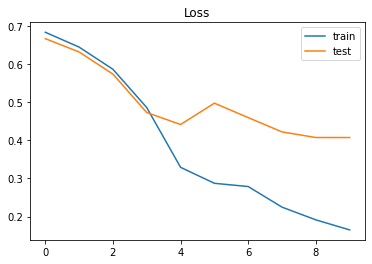

In [81]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

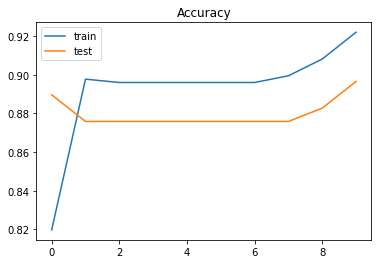

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [82]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)

from sklearn.metrics import classification_report
target_names = ['real','fake']
print(classification_report(Y_test, result, target_names=target_names))

   
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df

8/8 - 3s - 3s/epoch - 375ms/step
              precision    recall  f1-score   support

        real       0.92      1.00      0.96       210
        fake       1.00      0.14      0.24        22

    accuracy                           0.92       232
   macro avg       0.96      0.57      0.60       232
weighted avg       0.92      0.92      0.89       232



,real,fake
real,210,0
fake,19,3


### ORTADA

In [83]:
df_mid["Message"] = df_mid["Message"].str.lower()

In [84]:
df_mid['Message']= df_mid['Message'].str.replace(r'[^A-Za-z0-9 .]+', ' ') 

maxSeq = len(df_mid["Message"][0])
for i in range (0,len(df_mid["Message"])):
    try:
        cur = len(df_mid["Message"][i])
        if (cur > maxSeq):
            maxSeq = cur
    except:
        pass

df_mid.dropna(inplace=True)

<ipython-input-84-ea2990828e20>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_mid['Message']= df_mid['Message'].str.replace(r'[^A-Za-z0-9 .]+', ' ')


In [85]:
from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df_mid.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_mid['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
X = tokenizer.texts_to_sequences(df_mid['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df_mid['Category'] = labelencoder.fit_transform(df_mid['Category'])
Y = df_mid['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (926, 29508)
Shape of label tensor: (926,)


In [86]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(694, 29508) (694,)
(232, 29508) (232,)


In [87]:
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

print(history.model.summary())

Epoch 1/10
5/5 [==============================] - 9s 1s/step - loss: 0.6826 - accuracy: 0.7712 - val_loss: 0.6620 - val_accuracy: 0.8849
Epoch 2/10
5/5 [==============================] - 6s 1s/step - loss: 0.6397 - accuracy: 0.8865 - val_loss: 0.6108 - val_accuracy: 0.8777
Epoch 3/10
5/5 [==============================] - 6s 1s/step - loss: 0.5675 - accuracy: 0.8847 - val_loss: 0.5137 - val_accuracy: 0.8777
Epoch 4/10
5/5 [==============================] - 6s 1s/step - loss: 0.4415 - accuracy: 0.8847 - val_loss: 0.3867 - val_accuracy: 0.8777
Epoch 5/10
5/5 [==============================] - 6s 1s/step - loss: 0.3377 - accuracy: 0.8847 - val_loss: 0.3631 - val_accuracy: 0.8777
Epoch 6/10
5/5 [==============================] - 6s 1s/step - loss: 0.3307 - accuracy: 0.8847 - val_loss: 0.3705 - val_accuracy: 0.8777
Epoch 7/10
5/5 [==============================] - 6s 1s/step - loss: 0.3183 - accuracy: 0.8847 - val_loss: 0.3571 - val_accuracy: 0.8777
Epoch 8/10
5/5 [=========================

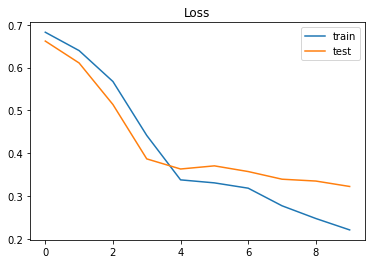

In [88]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

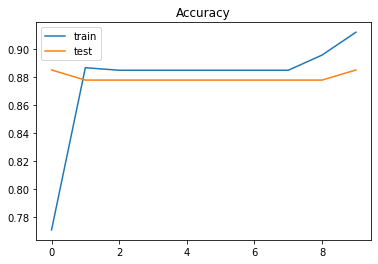

In [89]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [90]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)

from sklearn.metrics import classification_report
target_names = ['real','fake']
print(classification_report(Y_test, result, target_names=target_names))

   
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df

8/8 - 3s - 3s/epoch - 359ms/step
              precision    recall  f1-score   support

        real       0.92      1.00      0.96       211
        fake       1.00      0.10      0.17        21

    accuracy                           0.92       232
   macro avg       0.96      0.55      0.57       232
weighted avg       0.92      0.92      0.89       232



,real,fake
real,211,0
fake,19,2


###SONDA

In [91]:
df_tail["Message"] = df_tail["Message"].str.lower()
df_tail['Message']= df_tail['Message'].str.replace(r'[^A-Za-z0-9 .]+', ' ') 

maxSeq = len(df_tail["Message"][0])
for i in range (0,len(df_tail["Message"])):
    try:
        cur = len(df_tail["Message"][i])
        if (cur > maxSeq):
            maxSeq = cur
    except:
        pass

df_tail.dropna(inplace=True)

<ipython-input-91-a006ec4b28a2>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tail['Message']= df_tail['Message'].str.replace(r'[^A-Za-z0-9 .]+', ' ')


In [92]:
from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(df_tail.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_tail['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
X = tokenizer.texts_to_sequences(df_tail['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df_tail['Category'] = labelencoder.fit_transform(df_tail['Category'])
Y = df_tail['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (926, 29508)
Shape of label tensor: (926,)


In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(694, 29508) (694,)
(232, 29508) (232,)


In [94]:
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

print(history.model.summary())

Epoch 1/10
5/5 [==============================] - 8s 1s/step - loss: 0.6830 - accuracy: 0.7946 - val_loss: 0.6650 - val_accuracy: 0.8417
Epoch 2/10
5/5 [==============================] - 6s 1s/step - loss: 0.6435 - accuracy: 0.8955 - val_loss: 0.6270 - val_accuracy: 0.8417
Epoch 3/10
5/5 [==============================] - 6s 1s/step - loss: 0.5825 - accuracy: 0.8937 - val_loss: 0.5590 - val_accuracy: 0.8417
Epoch 4/10
5/5 [==============================] - 6s 1s/step - loss: 0.4673 - accuracy: 0.8937 - val_loss: 0.4448 - val_accuracy: 0.8417
Epoch 5/10
5/5 [==============================] - 6s 1s/step - loss: 0.3260 - accuracy: 0.8937 - val_loss: 0.4265 - val_accuracy: 0.8417
Epoch 6/10
5/5 [==============================] - 6s 1s/step - loss: 0.3025 - accuracy: 0.8937 - val_loss: 0.4513 - val_accuracy: 0.8417
Epoch 7/10
5/5 [==============================] - 6s 1s/step - loss: 0.2931 - accuracy: 0.8937 - val_loss: 0.4254 - val_accuracy: 0.8417
Epoch 8/10
5/5 [=========================

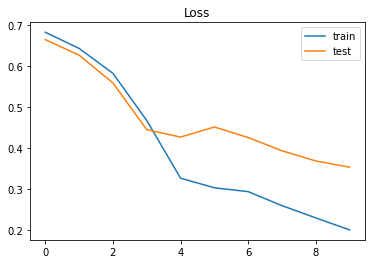

In [95]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

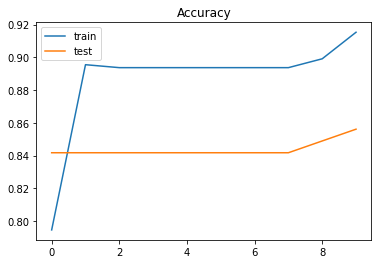

In [96]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [97]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)

from sklearn.metrics import classification_report
target_names = ['real','fake']
print(classification_report(Y_test, result, target_names=target_names))

   
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)
cm_df

8/8 - 3s - 3s/epoch - 381ms/step
              precision    recall  f1-score   support

        real       0.91      1.00      0.95       211
        fake       1.00      0.05      0.09        21

    accuracy                           0.91       232
   macro avg       0.96      0.52      0.52       232
weighted avg       0.92      0.91      0.88       232



,real,fake
real,211,0
fake,20,1
